<h2>Imports

In [22]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,f1_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [23]:
df = pd.read_csv('eth_txn_unscaled_Vars.csv')
                 #'../Data/address_data_combined.csv')
df.columns

Index(['address', 'avg_min_between_sent_txn', 'avg_min_between_received_txn',
       'time_diff_between_first_and_last_mins',
       'unique_received_from_addresses', 'min_val_received',
       'max_val_received', 'min_val_sent', 'avg_val_sent',
       'total_transactions_inc_cnts', 'total_ether_received',
       'total_ether_balance', 'flag'],
      dtype='object')

In [24]:
df.isin([np.nan, np.inf, -np.inf]).any()

address                                  False
avg_min_between_sent_txn                 False
avg_min_between_received_txn             False
time_diff_between_first_and_last_mins    False
unique_received_from_addresses           False
min_val_received                         False
max_val_received                         False
min_val_sent                             False
avg_val_sent                             False
total_transactions_inc_cnts              False
total_ether_received                     False
total_ether_balance                      False
flag                                     False
dtype: bool

In [25]:
X = df.drop(columns=['address', 'flag'])
y = df['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [26]:
columns = list(X.columns)

X_train_df = pd.DataFrame(X_train, columns=columns)
X_test_df = pd.DataFrame(X_test, columns=columns)

scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
  X_train[c] = X_train[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
import pickle

In [45]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [27]:
params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(1000,1500,100),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [28]:
clf = XGBClassifier(
    objective= 'binary:logistic',
    seed=42,
    n_jobs=-1,
    verbosity=0,
    silent=True,
)

In [8]:
tuned_clf = GridSearchCV(estimator=clf,
                         param_grid=params,
                         scoring='f1',
                         cv=5,
                         verbose=0,
                         ).fit(X_train,y_train)

In [9]:
print("Tuned Hyperparameters :", tuned_clf.best_params_)
print("Train F1 Score :",tuned_clf.best_score_)
best_y_pr = tuned_clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1200}
Train F1 Score : 0.8697088488299058
Test F1 Score:  0.8804071246819338


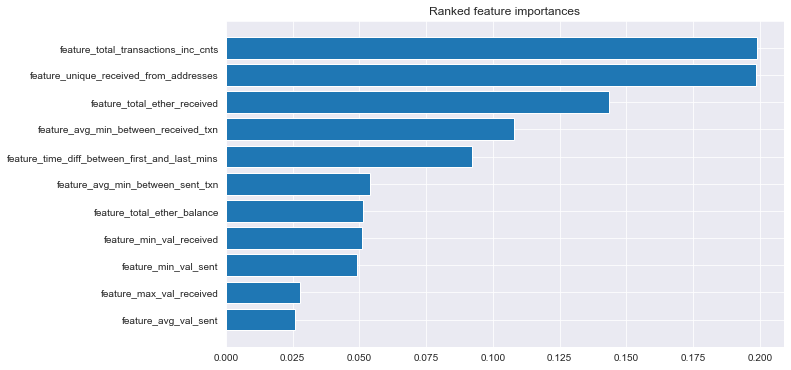

In [10]:
from matplotlib import pyplot as plt
feat_importances = tuned_clf.best_estimator_.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [39]:
tuned_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [40]:
tuned_clf.best_score_

0.8697088488299058

In [41]:
y_pred = tuned_clf.predict(X_test)
xgb_accuracy_score = accuracy_score(y_test, y_pred)
xgb_auc_score = roc_auc_score(y_test, y_pred)
print('XGBoost model accuracy score: {0:0.4f}'
      'and roc_auc score: {0:0.4f}'. format(xgb_accuracy_score,xgb_auc_score))

XGBoost model accuracy score: 0.9650and roc_auc score: 0.9650


In [43]:
y_pred_prob = tuned_clf.predict_proba(X_test)
y_pred_prob

array([[9.9996918e-01, 3.0795680e-05],
       [9.9841684e-01, 1.5831467e-03],
       [9.9999660e-01, 3.3905053e-06],
       ...,
       [9.9999893e-01, 1.0760606e-06],
       [9.9999875e-01, 1.2638611e-06],
       [9.9994516e-01, 5.4831202e-05]], dtype=float32)

<h2>Overall Average Performance

    <h2>Model Confusion Matrix and Statistics

Model Confusion Matrix Statistics:

 recall: 0.8543

 false_neg_rate: 0.1457

 false_pos_rate: 0.0153

 true_neg_rate: 0.9847

 positive_liklihood_ratio: 55.7017

 neg_liklihood_rate: 0.1479

 precision: 0.9081

 false_omission_rate: 0.0256

 false_discovery_rate: 0.0919

 neg_pred_value: 0.9744

 markedness: 0.8826

 diagnostic_odds_ration: 376.4949

 informedness: 0.8390

 prevalence_threshold: 0.1182

 prevalence: 0.1507

 accuracy: 0.9650

 balanced_accuracy: 0.9195

 F1_score: 0.8804

 fowlkes_mallows_index: 0.8808

 jaccard_index: 0.7864


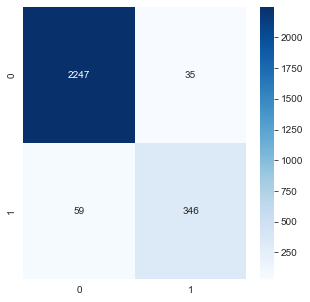

In [35]:
def model_diagnostic_stats(confusion_matrix):
    tp = confusion_matrix[1,1]
    tn = confusion_matrix[0,0]
    fp = confusion_matrix[0,1]
    fn = confusion_matrix[1,0]

    p = tp + fn
    n = fp + tn
    pp = tp + fp
    pn = fn + tn

    diagnostic_dict = {
    'recall' : tp/p,
    'false_neg_rate' : fn/p,
    'false_pos_rate' : fp/n,
    'true_neg_rate' : tn/n,
    'positive_liklihood_ratio' : (tp/p)/(fp/n),
    'neg_liklihood_rate' : (fn/p)/(tn/n),
    'precision' : tp/pp,
    'false_omission_rate' : fn/pn,
    'false_discovery_rate' : fp/pp,
    'neg_pred_value' : tn/pn,
    'markedness' : (tp/pp)+(tn/pn)-1,
    'diagnostic_odds_ration' : ((tp/p)/(fp/n))/( (fn/p)/(tn/n)),
    'informedness' : (tp/p)+(tn/n)-1,
    'prevalence_threshold' : (sqrt((tp/p)*(fp/n))-(fp/n))/((tp/p)-(fp/n)),
    'prevalence' : p/(p+n),
    'accuracy' : (tp+tn)/(p+n),
    'balanced_accuracy' : ((tp/p)+(tn/n))/2,
    'F1_score' : 2*tp/(2*tp+fp+fn),
    'fowlkes_mallows_index' : sqrt((tp/pp)*(tp/p)),
    'jaccard_index' : tp/(tp+fn+fp),
    }

    return diagnostic_dict
cm_matrix = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sb.heatmap(cm_matrix,annot=True,fmt='g',cmap="Blues")
stats = model_diagnostic_stats(cm_matrix)
print('Model Confusion Matrix Statistics:')
for key,value in stats.items():
    value_str = '%.4f' % value
    print("\n {}: {}".format(key,value_str))


<h2>Feature Importance Plot

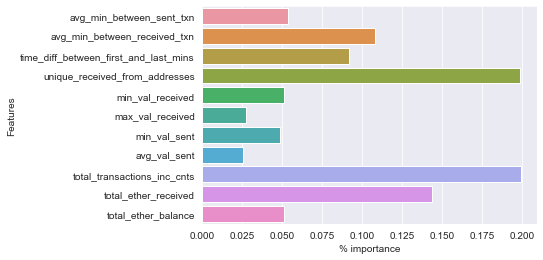

In [33]:
feature_importances = tuned_clf.best_estimator_.feature_importances_
column_var = X_train_df.columns.tolist()
feature_imprt_df = pd.DataFrame({'Features':column_var, '% importance': feature_importances})
formatted_vars_display = [ '%.3f' % elem for elem in feature_importances ]
ax = sb.barplot(x='% importance', y='Features',data=feature_imprt_df)
ax.set(xlabel='% importance', ylabel='Features')
plt.show()


In [34]:
# Save the model

In [20]:
import pickle
filename = 'xgboost_model.pkl'
pickle.dump(tuned_clf, open(filename, 'wb'))

In [21]:
!pwd

/Users/antares/PycharmProjects/eth_fraud_ml/ETH-scam-ml/modded
